In [5]:
import qiskit
qiskit.__version__

'2.1.1'

In [3]:
!python --version

Python 3.12.3


In [1]:
!python -m pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2


In [ ]:
%pip install --upgrade qiskit qiskit_ibm_runtime

   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ----------------------------- ---------- 2.4/3.2 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 3.2/3.2 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: qiskit_ibm_runtime
    Found existing installation: qiskit-ibm-runtime 0.29.0
    Uninstalling qiskit-ibm-runtime-0.29.0:
      Successfully uninstalled qiskit-ibm-runtime-0.29.0


## Week 5: Grover 알고리즘 기초
### 문제 1: "2큐비트 Grover 검색"
```python
# 2큐비트 시스템에서 Grover 알고리즘 구현:

# 요구사항:
# 1. 다음 상태들을 찾는 오라클 구현:
#    - |11⟩ 상태 검색
#    - |10⟩ 상태 검색
#    - (|00⟩ 또는 |11⟩) 상태 검색
# 2. 각 경우에 대해:
#    - 이론적 최적 반복 횟수 계산
#    - 실제 구현 및 측정
#    - 성공 확률 계산
# 3. 반복 횟수에 따른 성공 확률 변화 그래프 작성
```

### 문제 2: "데이터베이스 검색"
```python
# 4개 항목 데이터베이스에서 특정 항목 검색:

# 요구사항:
# 1. 다음 데이터베이스 구현:
#    - 항목: 00, 01, 10, 11
#    - 각 항목에 대한 표시 함수 f(x) 구현
# 2. 다음 검색 수행:
#    - f(x) = 1 인 단일 항목 검색
#    - f(x) = 1 인 두 개 항목 검색
# 3. 각 경우의 최적 반복 횟수 결정
# 4. 고전적 검색과 속도 비교 분석
```

In [ ]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import grover_operator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
 
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states
 
    Here we assume all input marked states have the same number of bits
 
    Parameters:
        marked_states (str or list): Marked states of oracle
 
    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])
 
    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [
            ind
            for ind in range(num_qubits)
            if rev_target.startswith("0", ind)
        ]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        if zero_inds:
            qc.x(zero_inds)
        qc.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)
        if zero_inds:
            qc.x(zero_inds)
    return qc

In [4]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
MY_API_TOKEN="4x7TXUcN0ofq0LMMQrX8kAPG1hJ-iFxC-JqsoMkfJnNQ"

QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token=MY_API_TOKEN, overwrite=True)

num_qubits = 5
service = QiskitRuntimeService()
backend = service.least_busy(
#backend = service.backends(
    operational=True, simulator=False, min_num_qubits=num_qubits
)
backend.name

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-02 22:21:05,163: Default instance not set. Searching all available instances.


'ibm_torino'

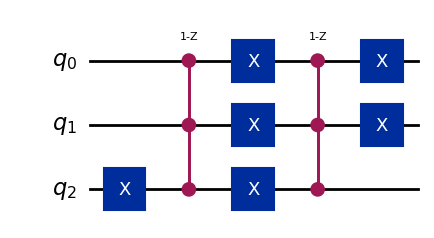

In [5]:
marked_states = ["011", "100"]
 
oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

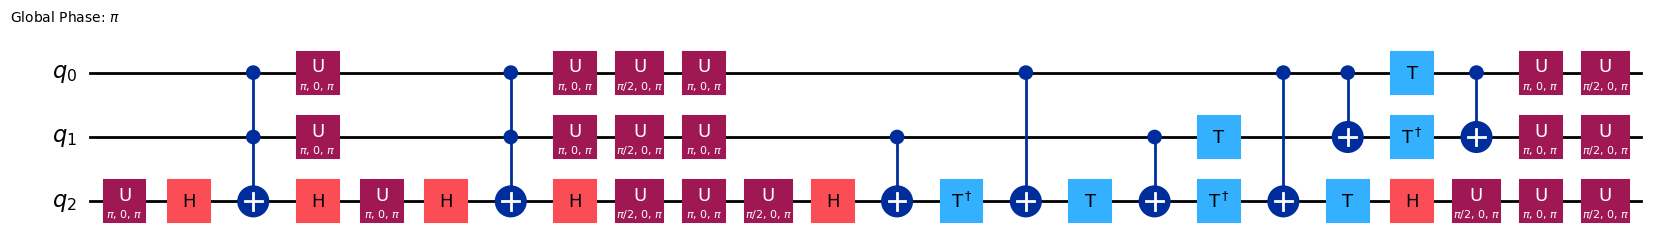

In [6]:
grover_op = grover_operator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [7]:
optimal_num_iterations = math.floor(
    math.pi
    / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
optimal_num_iterations

1

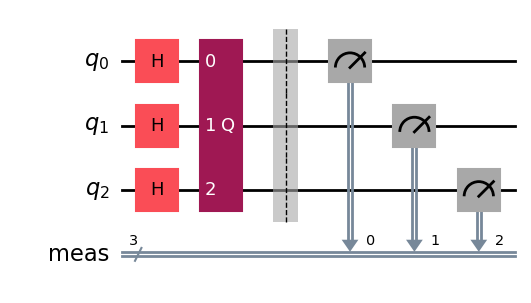

In [8]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

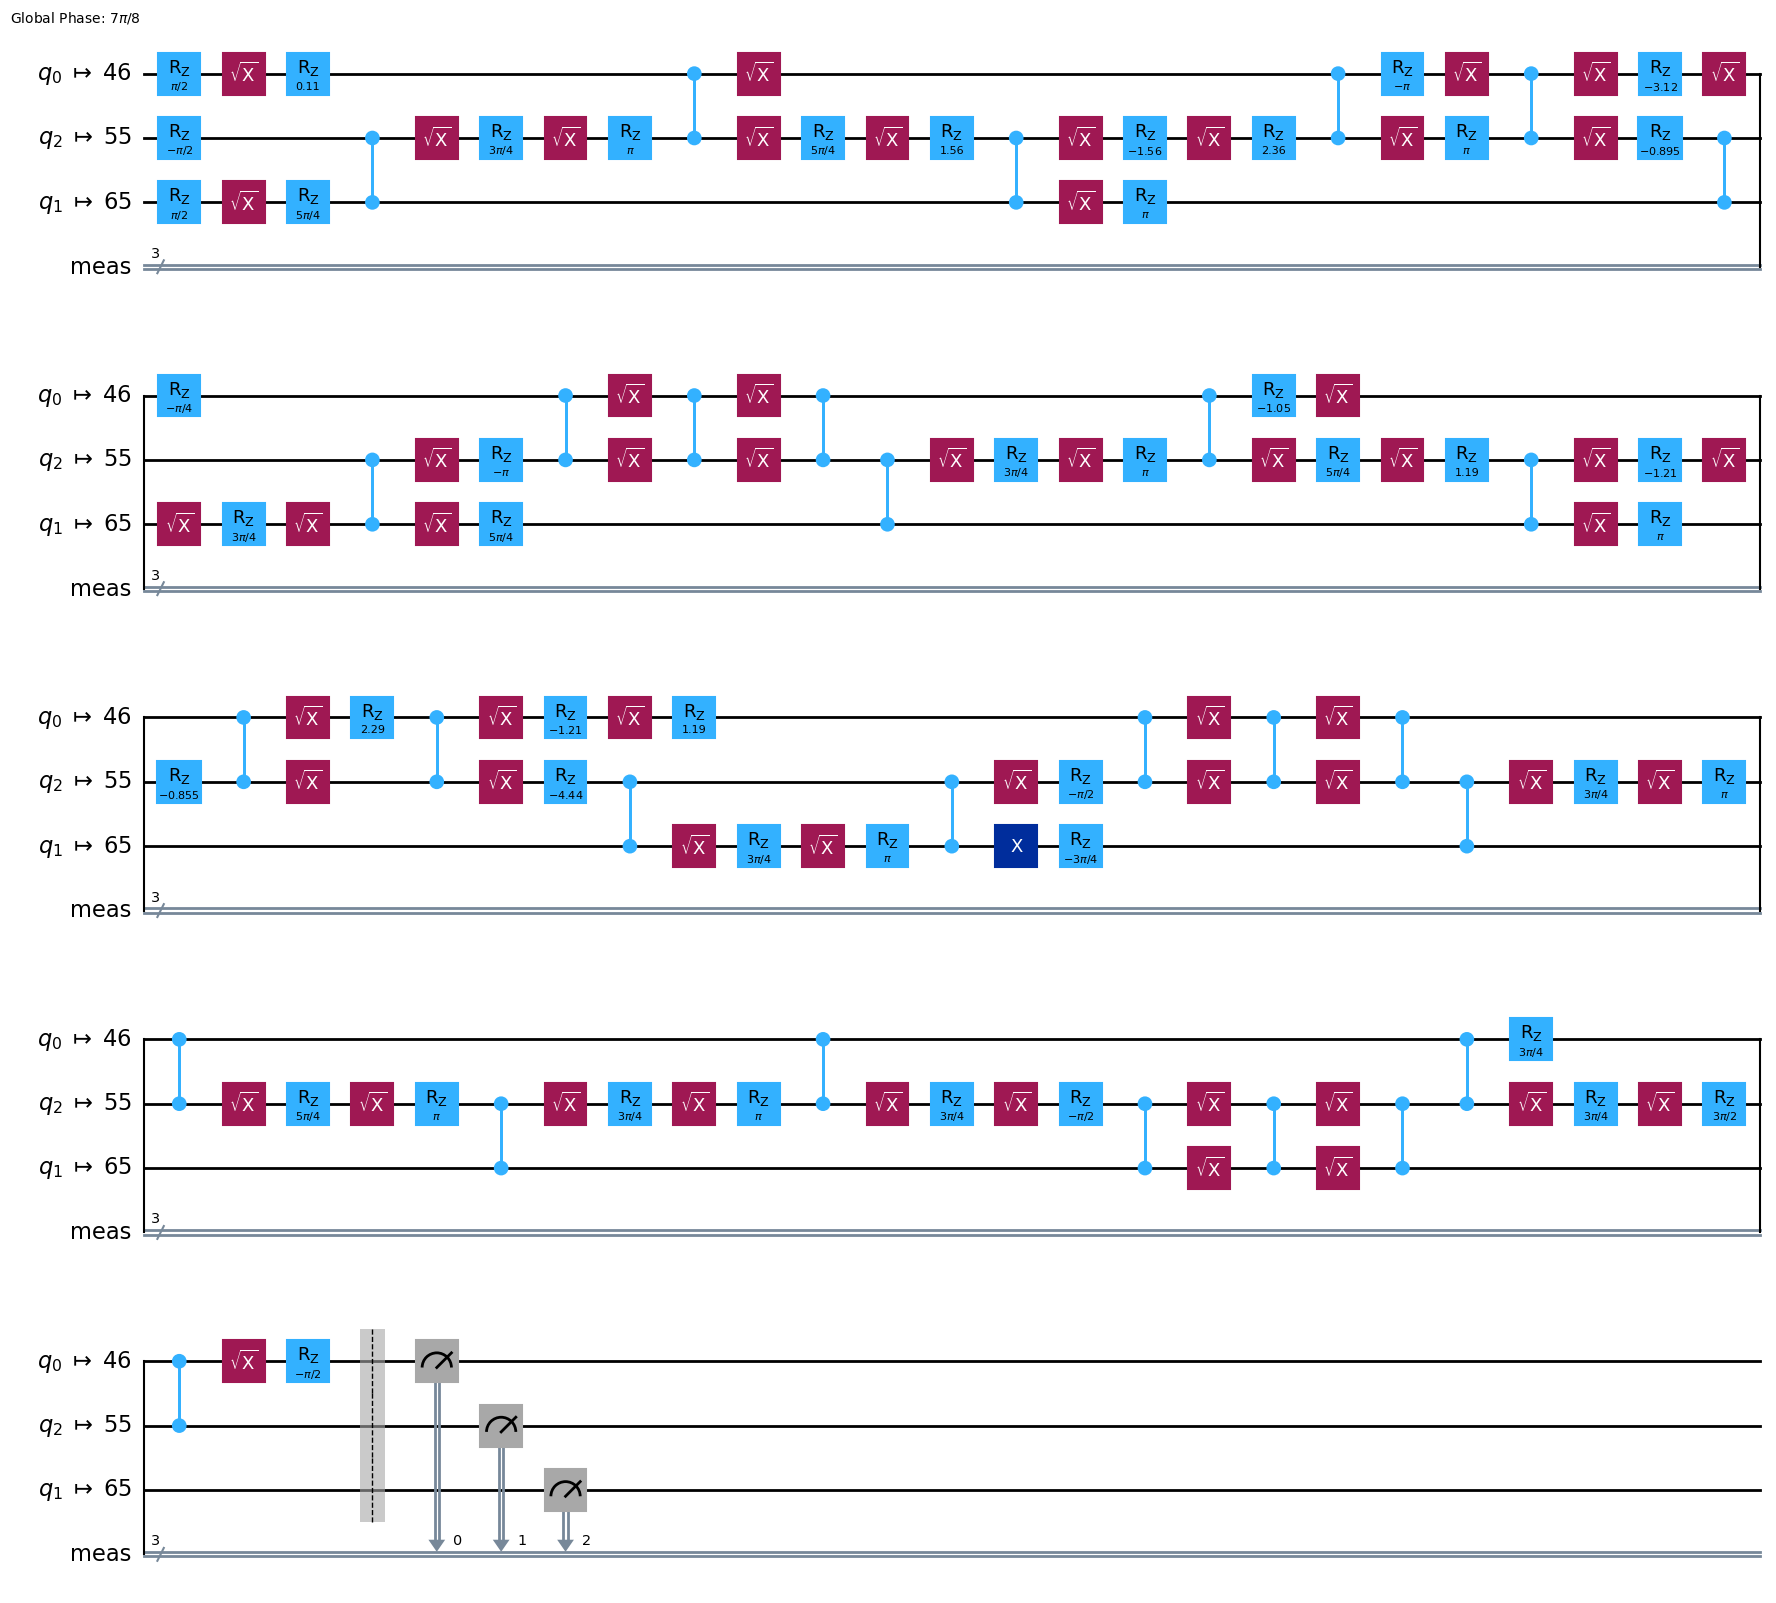

In [9]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [10]:
# To run on local simulator:
#   1. Use the StatevectorSampler from qiskit.primitives instead
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

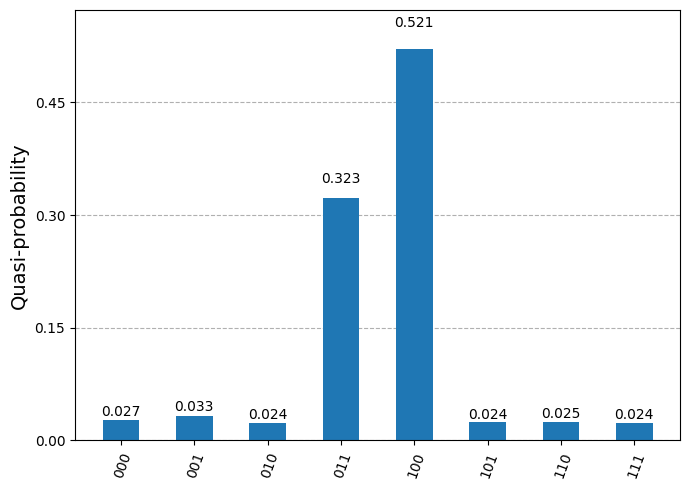

In [11]:
plot_distribution(dist)

In [12]:
from qiskit.primitives import StatevectorSampler

svsampler = StatevectorSampler(mode=backend)
svsampler.options.default_shots = 10_000
result = svsampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

TypeError: StatevectorSampler.__init__() got an unexpected keyword argument 'mode'